2023-12-12 Meeting

- Use click rate everywhere
- Implement Causal Model: + Reading
    - We divide every click rate by the article mean and the plug it in regression
- Make Regplot https://seaborn.pydata.org/generated/seaborn.regplot.html - should expect a clear upwards trend
- Taking the predictions of the correlational model and compare the top and least rated

In [1]:
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
import pandas as pd
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error
import numpy as np
from sklearn.linear_model import RidgeCV, LogisticRegression, LinearRegression
from torch.utils.data import DataLoader, TensorDataset
import csv
import torch 
import pickle
import random
from sklearn.metrics import accuracy_score
from scipy.stats import spearmanr
import math
import shap
#import langid
import re


In [2]:
#cpu/gpu
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

# Set random seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

No GPU available, using the CPU instead.


In [3]:
#Load data
df = pd.read_csv("upworthy-archive-confirmatory-packages-03.12.2020.csv", low_memory=False)
#adding index
df.reset_index(inplace=True,names=["embedding_id"])

#remove rows without eyecatcher_id (about 100)
has_eyecatcher_id = df['eyecatcher_id'].notna()
df = df.loc[has_eyecatcher_id]
#Create a new column for clickrate
df["clickrate"] = round((df["clicks"]/ df["impressions"]), ndigits=10)

#filter data based on same clickability_id and eyecatcher_id
df['headline_count'] = df.groupby(['clickability_test_id', 'eyecatcher_id']).headline.transform('count')
df.columns
# filter for all headlines with at least 2 pairs. 
df = df.loc[df['headline_count']>=2, ['clickability_test_id', 'excerpt', 'headline', 'lede', 'eyecatcher_id', 'clicks', 'headline_count',"embedding_id","clickrate","impressions"]]

# drop all rows with same headline, clickability_test_id and eyecatcher_id

#df = df.drop_duplicates(subset=["headline","clickability_test_id","eyecatcher_id"],keep=False)

cti = df[df.duplicated(subset=["headline","clickability_test_id","eyecatcher_id"],keep=False)].clickability_test_id
eti = df[df.duplicated(subset=["headline","clickability_test_id","eyecatcher_id"],keep=False)].eyecatcher_id
print(df.shape)
print("we removed: ",((df['clickability_test_id'].isin(cti) & df['eyecatcher_id'].isin(eti))).sum())
print(df[((df['clickability_test_id'].isin(cti) & df['eyecatcher_id'].isin(eti)))][['clickability_test_id', 'eyecatcher_id', 'headline']][:20])
df = df[~(df['clickability_test_id'].isin(cti) & df['eyecatcher_id'].isin(eti))]
print(df.shape)

#checking if it was successful
# -> could there be cases where there are duplicates and we only delete the headlines and not the whole experiment?
print(df[df["clickability_test_id"] == "546de9399ad54eca4800003c"]) #this is an example of matching headline, clickability test id and eyecatcher id
df = df.sort_values(by='headline_count', ascending=False)
#print(df.head())
#checking if there are any duplicates
#df = df.drop_duplicates(subset=["headline"]) ##this was before
##this is a new version
dupl_headline = df[df.duplicated(subset=["headline"])] 
## I believe we are removing too many values here - one of the duplicates we want to keep right?

#duplicated = df[dupl_headline]
ids = dupl_headline["clickability_test_id"]
eid = dupl_headline["eyecatcher_id"]


mask = df['clickability_test_id'].isin(ids)&df['eyecatcher_id'].isin(eid)
df = df[~mask]
print(df.shape) #too few observations :(
#print(df[df["clickability_test_id"] == "545181f8763e26efef000001"]) #those are staying because there are a lot of observations
#print(df[df["clickability_test_id"] == "54518b6da54be28ef000000b"]) #those are not staying because there a less packages within the test than then in the one above

# Capitalize all words in headline. (we do not have to regenerate embeddings because it does not care) 
df.headline = df.headline.str.title()

(72230, 10)
we removed:  21538
         clickability_test_id             eyecatcher_id  \
30   546de9399ad54eca4800003c  546de0d084ad380b59000031   
31   546de9399ad54eca4800003c  546de0d084ad380b59000031   
32   546de9399ad54eca4800003c  546de0d084ad380b59000031   
33   546de9399ad54eca4800003c  546de0d084ad380b59000031   
34   546de9399ad54eca4800003c  546de0d084ad380b59000031   
40   546deed784ad3817bc000057  546de75726714c6c44000041   
43   546deed784ad3817bc000057  546de75726714c6c44000041   
44   546deed784ad3817bc000057  546de75726714c6c44000041   
45   546deed784ad3817bc000057  546de75726714c6c44000041   
49   546df43d84ad385a0a000042  546de0d084ad380b59000031   
50   546df43d84ad385a0a000042  546de0d084ad380b59000031   
51   546df43d84ad385a0a000042  546de0d084ad380b59000031   
53   546df43d84ad385a0a000042  546de0d084ad380b59000031   
54   546df43d84ad385a0a000042  546de0d084ad380b59000031   
55   546df43d84ad385a0a000042  546de0d084ad380b59000031   
128  546e39c684ad38075200

In [4]:
# check that we remove all cases within experiment. 
df[(df['clickability_test_id']=='54ad5a2e65343000152d0000')
&(df['eyecatcher_id']=='54ad4e7b653430001e1c0000')]

,clickability_test_id,excerpt,headline,lede,eyecatcher_id,clicks,headline_count,embedding_id,clickrate,impressions


In [5]:
# check that there are no more duplicate headlines. 
len(df.headline.drop_duplicates()) == len(df)

False

In [6]:
#Checking for spanish headlines

#headlines = df['headline'].astype(str).tolist()
#results = [langid.classify(headline) for headline in headlines]
#log_file = "output_log.txt"

#with open(log_file, "w", encoding="utf-8") as log:
#    for headline,result in zip(headlines,results):
#        language = result
       
#        log.write(f"Sentence: {headline}, Identified Language: {language}\n")
#doesnt work amazingly for some reason and it just outputs all the sentences. The spanish ones are:
#Como Decir Todo … Sin Pronunciar Ninguna Palabra
#Ve La Protesta Que Todos Deben Conocer, Pero Que Nadie Puede Oir
#En Vez De ‘Sí Se Puede,’ Ya Es ‘Sí Se Shhhhhhhhh’?
#¿Cómo Se Dice ‘Nada’ En Español?
#all of them have the same clickability_id, so I would just remove them, because they are basically one experiment
print(df.shape)
df = df[df["clickability_test_id"] != "51436075220cb800020007b3"]
#checking if i dropped exactly 4
print(df.shape)

(34323, 10)
(34319, 10)


In [7]:
# Make tensor
clickrate = torch.tensor(df.clickrate.values)

In [8]:
print(df.groupby(["clickability_test_id"]).count().mean()) #average of 3.5 packages within one test
print(df.groupby(["clickability_test_id","eyecatcher_id"]).count().mean()) #average of 3.5 packages with the same eyecatcher id and same clickability_test_id
df.head()

excerpt           4.007624
headline          4.590556
lede              4.587212
eyecatcher_id     4.590556
clicks            4.590556
headline_count    4.590556
embedding_id      4.590556
clickrate         4.590556
impressions       4.590556
dtype: float64
excerpt           3.981528
headline          4.560664
lede              4.557342
clicks            4.560664
headline_count    4.560664
embedding_id      4.560664
clickrate         4.560664
impressions       4.560664
dtype: float64


,clickability_test_id,excerpt,headline,lede,eyecatcher_id,clicks,headline_count,embedding_id,clickrate,impressions
82811,541dd09b88aa4b01c3000001,Things that matter. Pass 'em on.,Earth’S Final Message To Earth Is Actually Rea...,<p>LIGHTBULB MOMENT: I think I figured out wha...,541dd246f509e102bb000005,13,17,82811,0.003135,4147
82805,541dd09b88aa4b01c3000001,Things that matter. Pass 'em on.,A Psa So Funny And Weird It Might Actually Get...,<p>This is the first 'save the Earth' PSA (pla...,541dd246f509e102bb000005,16,17,82805,0.003992,4008
63587,534a0b4e55c9d331f2000019,Things that matter. Pass 'em on. #PromotedPost,Watch This Fantastically Cute And Uplifting Vi...,<p>The world can be a tough place sometimes fo...,5349d78bcef1f1e528000017,24,17,63587,0.011262,2131
62987,534a0b4e55c9d331f2000019,Things that matter. Pass 'em on. #PromotedPost,Watch This Ridiculously Cute And Uplifting Vid...,<p>The world can be a tough place sometimes fo...,5349d78bcef1f1e528000017,24,17,62987,0.011241,2135
14325,534a0b4e55c9d331f2000019,Things that matter. Pass 'em on. #PromotedPost,Watch This Ridiculously Cute And Uplifting Vid...,<p>The world can be a tough place sometimes fo...,5349d78bcef1f1e528000017,24,17,14325,0.011289,2126


In [9]:
#Load prerun embeddings of all-mpnet-base-v2
with open('duplicates_removed_embeddings.pkl', "rb") as fIn:
    stored_data = pickle.load(fIn)
    stored_sentences = stored_data['headlines']
    stored_embeddings = stored_data['embeddings']
#embeddings = [stored_embeddings[stored_sentences.index.get_loc(headline)] for headline in df.headline]
#make sure we are getting the right embeddings: 

    
#remove rows without eyecatcher_id
#stored_sentences = stored_sentences[has_eyecatcher_id]
#stored_embeddings = stored_embeddings[has_eyecatcher_id]

## 1.1 Predicting clickrate from headline embeddings with Ridge regression


In [10]:
# Model
print(stored_embeddings.shape)
X_train, X_test, y_train, y_test = train_test_split(stored_embeddings, clickrate, test_size=0.2)

torch.Size([34319, 768])


In [11]:
# Ridge Model
ridge_model =RidgeCV(alphas=[0.001,0.002,0.005,0.01,0.05,0.07,0.2,0.4,0.6, 1, 10],store_cv_values=True)
ridge_model.fit(X_train, y_train)
ridge_model.score(X_train,y_train)
predictions = ridge_model.predict(X_test)
rmse = mean_squared_error(y_test, predictions)
print("Ridge Regression MSE for click difference:", rmse)
print("Ridge Regression R2 for click difference:", r2_score(y_true=y_test, y_pred=predictions))
df["predictions_ridge"] = ridge_model.predict(stored_embeddings)

Ridge Regression MSE for click difference: 9.480774719435703e-05
Ridge Regression R2 for click difference: 0.21715666211796325


## 1.2 Predicting clickrate from headline embeddings with Linear regression

In [12]:
# Linear Model
linear_model =LinearRegression()
linear_model.fit(X_train, y_train)
linear_model.score(X_train,y_train)
predictions = linear_model.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
print("Linear Regression MSE for clicks:", rmse)
print("Linear Regression R2 for clicks:", r2_score(y_true=y_test, y_pred=predictions))
df["predictions_linear"] = linear_model.predict(stored_embeddings)

Linear Regression MSE for clicks: 0.009762461569364592
Linear Regression R2 for clicks: 0.21304534717385804


## 1.3 Visualizing predicted clicks vs actual clicks

0.03488030559218707


[Text(0, 0.5, 'true clickrate'), Text(0.5, 0, 'predicted clickrate')]

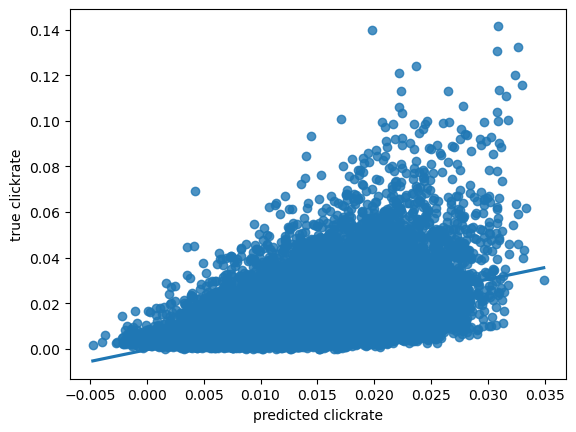

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
# print stuff. 
predictions = ridge_model.predict(stored_embeddings)
print(predictions.max())
# visualize real and predicted values
fig, ax = plt.subplots()
sns.regplot(x = predictions, y = df.clickrate, ax=ax)
ax.set(ylabel = 'true clickrate', xlabel = 'predicted clickrate')

## 2.Causal Model 

Implement Causal Model: + Reading
    - We divide every click rate by the article mean and the plug it in regression

In [14]:
#calculating mean per clickability_test_id and eyecatcher_id
df["means"] = df.groupby(["clickability_test_id","eyecatcher_id"])["clickrate"].transform("mean")
df.columns
df["adjusted_clickrate"] = df['clickrate']-df['means']
# set rows with 0 clicks -> adjusted clickrates NA - set to zero
#df["adjusted_clickrate"] = df["adjusted_clickrate"].fillna(0)
print(df["adjusted_clickrate"].isna().sum())
adjusted_clickrate = torch.tensor(df.adjusted_clickrate.values)

0


In [15]:
# What do we do with headlines that did not get any clicks? 
# Will they just have an adjusted clickrate of zero?
df.loc[(df["clickrate"]/df["means"]).isna(), ['headline', 'eyecatcher_id', 'clicks', 'impressions', 'means', 'clickrate']]

,headline,eyecatcher_id,clicks,impressions,means,clickrate


## 2.1 Causal model with Ridge Regression 

In [16]:
X_train, X_test, y_train, y_test = train_test_split(stored_embeddings, adjusted_clickrate, test_size=0.2)
causal_ridge_model =RidgeCV(alphas=[0.001,0.002,0.005,0.01,0.05,0.07,0.2,0.4,0.6, 1, 10],store_cv_values=True)
causal_ridge_model.fit(X_train, y_train)
causal_ridge_model.score(X_train,y_train)
causal_predictions_rg = causal_ridge_model.predict(X_test)
rmse = mean_squared_error(y_test, causal_predictions_rg)
print("Causal Ridge Regression MSE for click difference:", rmse)
print("Causal Ridge Regression R2 for click difference:", r2_score(y_true=y_test, y_pred=causal_predictions_rg))
df["causal_predictions_ridge"] = causal_ridge_model.predict(stored_embeddings)

Causal Ridge Regression MSE for click difference: 1.6098233045383515e-05
Causal Ridge Regression R2 for click difference: 0.05273320429704642


## 2.2 Causal model with Linear Regression

Causal Linear Regression MSE for clicks: 0.0040397761423545805
Causal Linear Regression R2 for clicks: 0.03969607415397036


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


<Axes: xlabel='causal_predictions_linear', ylabel='Count'>

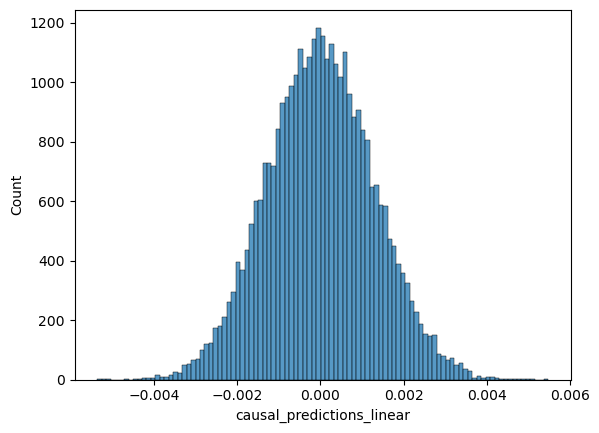

In [17]:
causal_linear_model =LinearRegression()
causal_linear_model.fit(X_train, y_train)
causal_linear_model.score(X_train,y_train)
causal_predictions_lm = causal_linear_model.predict(X_test)
rmse = mean_squared_error(y_test, causal_predictions_lm, squared=False)
print("Causal Linear Regression MSE for clicks:", rmse)
print("Causal Linear Regression R2 for clicks:", r2_score(y_true=y_test, y_pred=causal_predictions_lm))
df["causal_predictions_linear"] = causal_linear_model.predict(stored_embeddings)
sns.histplot(df["causal_predictions_linear"])

## 3.1 Compare top / bottom 20 causal model with correlational model - Ridge Regression


In [18]:
from ipywidgets import widgets, Layout
from IPython import display


last20_pred = df.sort_values(["predictions_ridge"],ascending=True).loc[:,['headline']][:20]
last20_pred_causal = df.sort_values(["causal_predictions_ridge"],ascending=True).loc[:,['headline']][:20]
widget1 = widgets.Output()
widget2 = widgets.Output()

# render in output widgets
with widget1:
    display.display(last20_pred.style.set_caption('Last 20 Ridge'))
    last20_pred.info()
with widget2:
    display.display(last20_pred_causal.style.set_caption('Last 20 Causal'))
    last20_pred_causal.info()


# add some CSS styles to distribute free space
box_layout = Layout(display='flex',
                    flex_flow='row',
                    justify_content='space-around',
                    width='auto'
                   )
    

box = widgets.HBox([widget1, widget2], layout=box_layout)
box

In [19]:
#Checking for intersection
np.intersect1d(last20_pred.values,last20_pred_causal.values)

array(["Can We Make Space To Hear People'S Stories, Or Are Corporations The Only Ones With A Voice?",
       'Solidarity Is For Everyone But Those Who Really Need It'],
      dtype=object)

In [20]:
first20_pred = df.sort_values(["predictions_ridge"],ascending=False).loc[:,['headline']][:20]
first20_pred_causal = df.sort_values(["causal_predictions_ridge"],ascending=False).loc[:,['headline']][:20]
widget1 = widgets.Output()
widget2 = widgets.Output()

# render in output widgets
with widget1:
    display.display(first20_pred.style.set_caption('First 20 Ridge'))
    first20_pred.info()
with widget2:
    display.display(first20_pred_causal.style.set_caption('First 20 Causal'))
    first20_pred_causal.info()


# add some CSS styles to distribute free space
box_layout = Layout(display='flex',
                    flex_flow='row',
                    justify_content='space-around',
                    width='auto'
                   )
    

box = widgets.HBox([widget1, widget2], layout=box_layout)
box

In [21]:
np.intersect1d(first20_pred.values,first20_pred_causal.values)

array(['A Lot Of People Have Already Seen This Jim Carrey Clip. But Did They See What I Saw?',
       'This Girl Got Asked An Incredibly Lewd Question By A Total Stranger. Her Response? Ah-Mazing.',
       'You Might Have Already Seen This Jim Carrey Clip. But Did You See What I Saw?'],
      dtype=object)

In [22]:
df["predictions_linear"]

82811    0.014093
82805    0.009135
63587    0.014995
62987    0.016823
14325    0.016592
           ...   
29520    0.015290
29587    0.016719
29588    0.012066
58772    0.020301
29439    0.008856
Name: predictions_linear, Length: 34319, dtype: float32

## 3.1 Compare top / bottom 20 causal model with correlational model - Linear

In [23]:
last20_pred = df.sort_values(["predictions_linear"],ascending=True).loc[:,['headline']][:20]
last20_pred_causal = df.sort_values(["causal_predictions_linear"],ascending=True).loc[:,['headline']][:20]
widget1 = widgets.Output()
widget2 = widgets.Output()

# render in output widgets
with widget1:
    display.display(last20_pred.style.set_caption('Last 20 Linear'))
    last20_pred.info()
with widget2:
    display.display(last20_pred_causal.style.set_caption('Last 20 Causal'))
    last20_pred_causal.info()


# add some CSS styles to distribute free space
box_layout = Layout(display='flex',
                    flex_flow='row',
                    justify_content='space-around',
                    width='auto'
                   )
    

box = widgets.HBox([widget1, widget2], layout=box_layout)
box

In [24]:
#Checking for intersection
np.intersect1d(last20_pred.values,last20_pred_causal.values)

array(["Can We Make Space To Hear People'S Stories, Or Are Corporations The Only Ones With A Voice?"],
      dtype=object)

In [25]:
first20_pred = df.sort_values(["predictions_linear"],ascending=False).loc[:,['headline']][:20]
first20_pred_causal = df.sort_values(["causal_predictions_linear"],ascending=False).loc[:,['headline']][:20]
widget1 = widgets.Output()
widget2 = widgets.Output()

# render in output widgets
with widget1:
    display.display(first20_pred.style.set_caption('First 20 Linear'))
    first20_pred.info()
with widget2:
    display.display(first20_pred_causal.style.set_caption('First 20 Causal'))
    first20_pred_causal.info()


# add some CSS styles to distribute free space
box_layout = Layout(display='flex',
                    flex_flow='row',
                    justify_content='space-around',
                    width='auto'
                   )
    

box = widgets.HBox([widget1, widget2], layout=box_layout)
box

In [26]:
#Checking for intersection
np.intersect1d(first20_pred.values,first20_pred_causal.values)

array(['This Girl Got Asked An Incredibly Lewd Question By A Total Stranger. Her Response? Ah-Mazing.',
       'You Might Have Already Seen This Jim Carrey Clip. But Did You See What I Saw?'],
      dtype=object)

## 4.1 Shapley Values Ridge Regression predicting Clickrate

In [27]:
# load the model

# here we also need embeddings - the whole thing is our model
model = SentenceTransformer(
    "sentence-transformers/all-mpnet-base-v2")

# this defines an explicit python function that takes a list of strings and outputs scores for each class
def f(x):
    embedding = model.encode(x)
    return ridge_model.predict(embedding)

In [28]:
#defining masker - the masker specifies how to hide portions of the input
method = "default masker" #before it was custo tokenizer, but it works the same with the default one so i would say remove everything and just leave the defining of the whitespace masker

# build an explainer by passing a transformers tokenizer
if method == "transformers tokenizer":
    explainer = shap.Explainer(f)

# build an explainer by explicitly creating a masker
elif method == "default masker":
    masker  = shap.maskers.Text("\W|'")   # this will create a basic whitespace tokenizer.
    #A whitespace tokenizer breaks a text into tokens based on whitespace characters (spaces, tabs, newlines,/, etc.)
    explainer = shap.Explainer(f, masker)



### 4.1.1 Checking Shap values for top 20 predictions made with ridge

In [29]:
top_values = df.sort_values(["predictions_ridge"],ascending=False).loc[:,['headline']][:20]
#removing duplicates, so they dont influence the overall 
top_values = top_values.drop_duplicates(keep='first')
top_shap_values_ridge = explainer(top_values["headline"])


Partition explainer:  55%|██████████████████████████████████████████████████████████████████████▍                                                         | 11/20 [00:26<00:24,  2.69s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 21it [00:56,  3.55s/it]                                                                                                                                              


In [30]:
#predictions = ridge_model.predict(stored_embeddings[0].reshape(1,-1)) # i am not sure what is that and if we need it ??

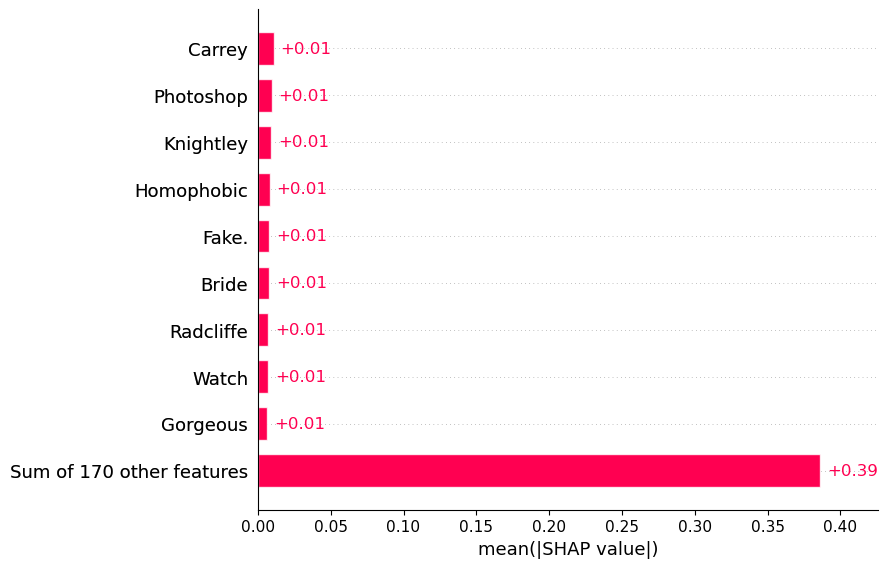

In [31]:
for i in range(5): #just checking for 5 of them for example
    shap.plots.text(top_shap_values_ridge[i])
shap.plots.bar(top_shap_values_ridge)

### 4.1.2 Checking for least 20 if there are words that had negative impact, because they will be the ones that will make the click rate lower

In [32]:
lowest_values = df.sort_values(["predictions_ridge"],ascending=True).loc[:,['headline']][:20]
lowest_values["headline"]
lowest_values = lowest_values.drop_duplicates(keep='first')
lowest_shap_values_ridge = explainer(lowest_values["headline"])


Partition explainer: 21it [00:43,  2.40s/it]                                                                                                                                              


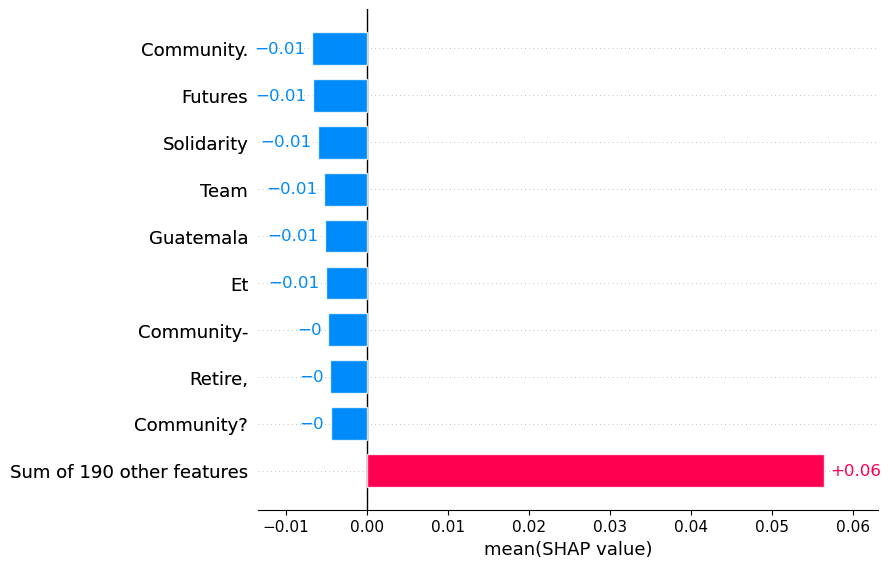

In [33]:
for i in range(5):
    shap.plots.text(lowest_shap_values_ridge[i])
shap.plots.bar(lowest_shap_values_ridge.mean(0),order=shap.Explanation.argsort)

## 4.2 Shapley Values Linear Regression predicting Clickrate

In [34]:
# load the model

# here we also need embeddings - the whole thing is our model
model = SentenceTransformer(
    "sentence-transformers/all-mpnet-base-v2")

# this defines an explicit python function that takes a list of strings and outputs scores for each class
def f(x):
    embedding = model.encode(x)
    return linear_model.predict(embedding)

In [35]:
#defining masker - the masker specifies how to hide portions of the input
method = "default masker" #before it was custo tokenizer, but it works the same with the default one so i would say remove everything and just leave the defining of the whitespace masker

# build an explainer by passing a transformers tokenizer
if method == "transformers tokenizer":
    explainer = shap.Explainer(f)

# build an explainer by explicitly creating a masker
elif method == "default masker":
    masker  = shap.maskers.Text("\W|'")   # this will create a basic whitespace tokenizer.
    #A whitespace tokenizer breaks a text into tokens based on whitespace characters (spaces, tabs, newlines,/, etc.)
    explainer = shap.Explainer(f, masker)


### 4.2.1 Checking for shap values for top 20 predictions made with linear regression

In [36]:
top_values = df.sort_values(["predictions_linear"],ascending=False).loc[:,['headline']][:20]
#removing duplicates, so they dont influence the overall 
top_values = top_values.drop_duplicates(keep='first')
top_shap_values_linear = explainer(top_values["headline"])

Partition explainer: 21it [00:56,  3.34s/it]                                                                                                                                              


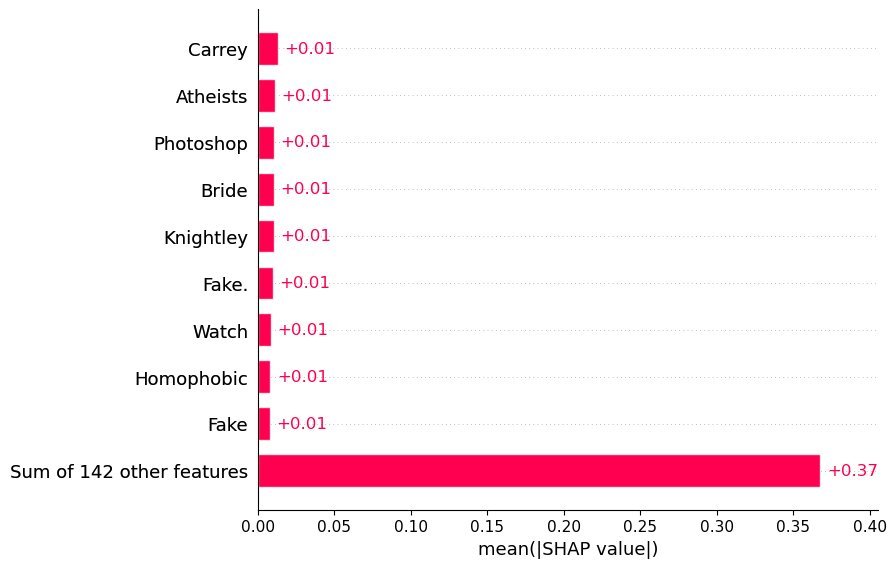

In [37]:
for i in range(5):
    shap.plots.text(top_shap_values_linear[i])
shap.plots.bar(top_shap_values_linear)

### 4.1.2 Checking for least 20 if there are words that had negative impact, because they will be the ones that will make the click rate lower

In [38]:
lowest_values = df.sort_values(["predictions_linear"],ascending=True).loc[:,['headline']][:20]
lowest_values = lowest_values.drop_duplicates(keep='first')
lowest_shap_values_linear = explainer(lowest_values["headline"])

Partition explainer: 21it [00:49,  3.07s/it]                                                                                                                                              


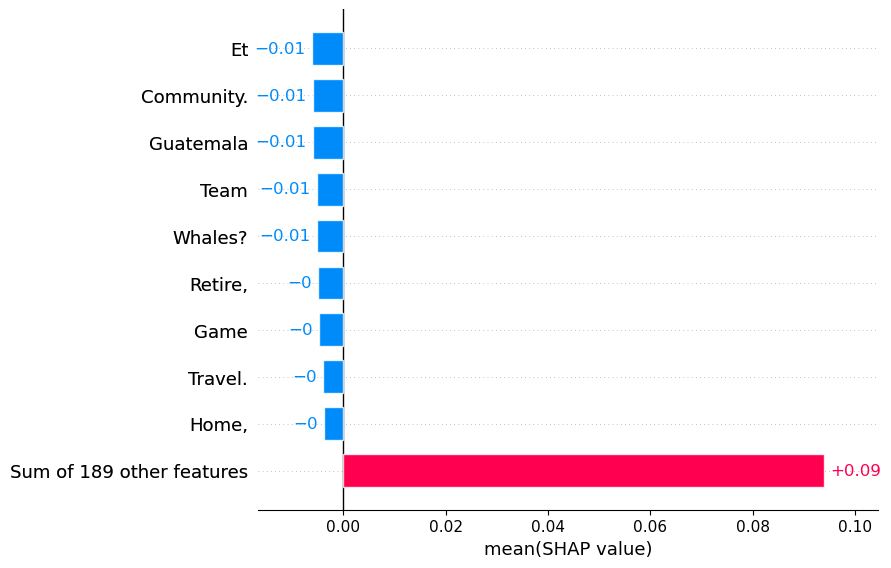

In [39]:
for i in range(5):
    shap.plots.text(lowest_shap_values_linear[i])
shap.plots.bar(lowest_shap_values_linear.mean(0),order=shap.Explanation.argsort)

## Idea: 
#1. Get 500 Most common words. 
#2. Pull all headlines with eg. first word. 
#3. Run new embedding space for all combinations - with word and without word. -> create strings without words, couple it to original somehow so that we can get difference later. 
#4. Predict number of clicks with these new embeddigns (without that word.)


### Using our subset of ignore words - propositions, articles and connectors

In [40]:
#1. Get 500 Most common words. 
# Python program to find the k most frequent words (Geek Website)
# from data set 
from collections import Counter 
  
# should we capitalize the words? Do upper and lower case letters make a difference in the embedding space? 
# Are the headlines in all capitalizations and all lower case close to each other?
# split() returns list of all the words in the string 

# 1st approach:removing articles, propositions, connectors, punctuation
punctuation = { ".", ",", "?", "!", ";", ":"}
propositions = {"a", "A", "an", "An", "the", "The", "about", "About", "above", "Above", "across", "Across", "after", "After", "against", "Against", "along", "Along", "am", "Am", "is", "Is", "are", "Are", "amid", "Amid", "among", "Among", "around", "Around", "as", "As", "at", "At", "before", "Before", "behind", "Behind", "below", "Below", "beneath", "Beneath", "beside", "Beside", "between", "Between", "beyond", "Beyond", "but", "But", "by", "By", "concerning", "Concerning", "considering", "Considering", "despite", "Despite", "down", "Down", "during", "During", "except", "Except", "for", "For", "from", "From", "in", "In", "inside", "Inside", "into", "Into", "like", "Like", "near", "Near", "of", "Of", "off", "Off", "on", "On", "onto", "Onto", "out", "Out", "outside", "Outside", "over", "Over", "past", "Past", "regarding", "Regarding", "round", "Round", "since", "Since", "so", "So", "than", "Than", "that", "That", "though", "Though", "through", "Through", "to", "To", "toward", "Toward", "under", "Under", "until", "Until", "unto", "Unto", "up", "Up", "upon", "Upon", "with", "With", "within", "Within", "without", "Without", "and", "And", "or", "Or", "nor", "Nor", "but", "But", "yet", "Yet", "so", "So", "although", "Although", "because", "Because", "however", "However", "moreover", "Moreover", "nevertheless", "Nevertheless", "therefore", "Therefore", "while", "While", "however", "However", "furthermore", "Furthermore"}
ignore = punctuation.union(propositions)
split_it = [word for headline in df.headline for word in re.findall(r"[\w']+|[.,!?;]", headline) if word not in ignore]
  
# Pass the split_it list to instance of Counter class. 
counter = Counter(split_it) 
  
# most_common() produces k frequently encountered 
# input values and their respective counts. 
## Do one version with all of them / look at them 
## Maybe remove:
# - articles and propositions
most_occur = np.array(counter.most_common(50))
most_occur

array([['You', '8290'],
       ['This', '6801'],
       ['It', '5981'],
       ['What', '4083'],
       ['I', '3163'],
       ['How', '3016'],
       ['They', '2957'],
       ['Be', '2867'],
       ['People', '2748'],
       ['Your', '2639'],
       ['He', '2606'],
       ['One', '2571'],
       ['If', '2536'],
       ['These', '2458'],
       ['We', '2424'],
       ['Her', '2422'],
       ['She', '2376'],
       ['Why', '2328'],
       ['Not', '2321'],
       ['When', '2262'],
       ['Have', '2252'],
       ['Just', '2067'],
       ["It'S", '2049'],
       ['Do', '1981'],
       ['His', '1947'],
       ['All', '1927'],
       ['Was', '1899'],
       ['S', '1895'],
       ['Can', '1720'],
       ['Their', '1604'],
       ['Some', '1595'],
       ['Who', '1588'],
       ['Women', '1377'],
       ['Them', '1367'],
       ['Way', '1365'],
       ['Get', '1331'],
       ["Here'S", '1297'],
       ['Make', '1267'],
       ['Know', '1252'],
       ['Kids', '1250'],
       ['Think', '1244'],

In [41]:
#2. Pull all headlines with the missing word - top 50
words = most_occur[:50,0]
words_removal_matrix = pd.DataFrame(columns=["Word","Max diff","Min diff"])

i = 0 
for word in words:    
    word_headlines = df[[word in re.findall(r"[\w']+|[.,!?;]", headline) for headline in df.headline]].copy()
   
    word_headlines['removed'] = [re.sub(r'\b{}\b'.format(word), '',headline) for headline in word_headlines.headline]
    model = SentenceTransformer('all-mpnet-base-v2')
#3. Run new embedding space for the headlines with words removed. 
#Embeddings
    removed_word_embeddings = model.encode(word_headlines.removed.values, convert_to_tensor=True,batch_size=32,show_progress_bar=True)
#4. Predict number of clicks with these new embeddigns and add as column to df. 
    word_headlines['removed_word_clickrate'] = causal_ridge_model.predict(removed_word_embeddings)
    removed_word_diff = word_headlines.removed_word_clickrate - word_headlines.causal_predictions_ridge
#5. Table: word, mean and max (removing the word increases the clickrate) and min (removing the word decreases the clickrate.)
   
    words_removal_matrix.loc[i,["Word","Median","Abs Mean","Max diff","Min diff"]] = word,np.median(removed_word_diff),np.mean(np.abs(removed_word_diff)),np.max(removed_word_diff),np.min(removed_word_diff)
    i += 1
words_removal_matrix
    

Batches:   0%|          | 0/208 [00:00<?, ?it/s]

Batches:   0%|          | 0/207 [00:00<?, ?it/s]

Batches:   0%|          | 0/169 [00:00<?, ?it/s]

Batches:   0%|          | 0/124 [00:00<?, ?it/s]

Batches:   0%|          | 0/81 [00:00<?, ?it/s]

Batches:   0%|          | 0/93 [00:00<?, ?it/s]

Batches:   0%|          | 0/80 [00:00<?, ?it/s]

Batches:   0%|          | 0/87 [00:00<?, ?it/s]

Batches:   0%|          | 0/83 [00:00<?, ?it/s]

Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Batches:   0%|          | 0/66 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/78 [00:00<?, ?it/s]

Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Batches:   0%|          | 0/67 [00:00<?, ?it/s]

Batches:   0%|          | 0/62 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batches:   0%|          | 0/72 [00:00<?, ?it/s]

Batches:   0%|          | 0/71 [00:00<?, ?it/s]

Batches:   0%|          | 0/70 [00:00<?, ?it/s]

Batches:   0%|          | 0/69 [00:00<?, ?it/s]

Batches:   0%|          | 0/65 [00:00<?, ?it/s]

Batches:   0%|          | 0/61 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batches:   0%|          | 0/55 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batches:   0%|          | 0/54 [00:00<?, ?it/s]

Batches:   0%|          | 0/53 [00:00<?, ?it/s]

Batches:   0%|          | 0/52 [00:00<?, ?it/s]

Batches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/49 [00:00<?, ?it/s]

Batches:   0%|          | 0/49 [00:00<?, ?it/s]

Batches:   0%|          | 0/43 [00:00<?, ?it/s]

Batches:   0%|          | 0/42 [00:00<?, ?it/s]

Batches:   0%|          | 0/42 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Batches:   0%|          | 0/39 [00:00<?, ?it/s]

Batches:   0%|          | 0/38 [00:00<?, ?it/s]

Batches:   0%|          | 0/38 [00:00<?, ?it/s]

Batches:   0%|          | 0/38 [00:00<?, ?it/s]

Batches:   0%|          | 0/37 [00:00<?, ?it/s]

Batches:   0%|          | 0/37 [00:00<?, ?it/s]

Batches:   0%|          | 0/36 [00:00<?, ?it/s]

Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Batches:   0%|          | 0/36 [00:00<?, ?it/s]

Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Batches:   0%|          | 0/34 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

,Word,Mean,Max diff,Min diff,Median,Abs Mean
0,You,NaN,0.001487,-0.001964,-0.000135,0.000228
1,This,NaN,0.001353,-0.002757,-0.000307,0.000410
2,It,NaN,0.001167,-0.00168,-0.000096,0.000173
3,What,NaN,0.001229,-0.001955,-0.000125,0.000280
4,I,NaN,0.001521,-0.001172,-0.000080,0.000178
5,How,NaN,0.001315,-0.002018,-0.000150,0.000283
6,They,NaN,0.001084,-0.001665,-0.000146,0.000256
7,Be,NaN,0.001207,-0.00115,-0.000026,0.000125
8,People,NaN,0.001155,-0.002081,-0.000173,0.000254
9,Your,NaN,0.000945,-0.001211,-0.000065,0.000187


### Using stopwords as a set of ignore words

In [42]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /Users/tonia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [43]:
capitalized = [word.capitalize() for word in stop_words]
ignore = stop_words + capitalized + list(punctuation)

In [44]:
split_it = [word for headline in df.headline for word in re.findall(r"[\w']+|[.,!?;]", headline) if word not in ignore]
  
# Pass the split_it list to instance of Counter class. 
counter = Counter(split_it) 
  
# most_common() produces k frequently encountered 
# input values and their respective counts. 
## Do one version with all of them / look at them 
## Maybe remove:
# - articles and propositions
most_occur = np.array(counter.most_common(50))
most_occur

#2. Pull all headlines with the missing word - top 20
words = most_occur[:20,0]
words_removal_matrix_stopwords = pd.DataFrame(columns=["Word","Max diff","Min diff"])

i = 0 
for word in words:
    
    word_headlines = df[[word in re.findall(r"[\w']+|[.,!?;]", headline) for headline in df.headline]].copy()
    
    word_headlines['removed'] = [re.sub(r'\b{}\b'.format(word), '',headline) for headline in word_headlines.headline]
    model = SentenceTransformer('all-mpnet-base-v2')
#3. Run new embedding space for the headlines with words removed. 
#Embeddings
    removed_word_embeddings = model.encode(word_headlines.removed.values, convert_to_tensor=True,batch_size=32,show_progress_bar=True)
#4. Predict number of clicks with these new embeddigns and add as column to df. 
    word_headlines['removed_word_clickrate'] = causal_ridge_model.predict(removed_word_embeddings)
    removed_word_diff = word_headlines.removed_word_clickrate - word_headlines.causal_predictions_ridge
#5. Table: word, mean and max (removing the word increases the clickrate) and min (removing the word decreases the clickrate.)
   
    words_removal_matrix_stopwords.loc[i,["Word","Median","Abs Mean","Max diff","Min diff"]] = word,np.median(removed_word_diff),np.mean(np.abs(removed_word_diff)),np.max(removed_word_diff),np.min(removed_word_diff)
    i += 1
words_removal_matrix_stopwords
    

Batches:   0%|          | 0/83 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/64 [00:00<?, ?it/s]

Batches:   0%|          | 0/61 [00:00<?, ?it/s]

Batches:   0%|          | 0/43 [00:00<?, ?it/s]

Batches:   0%|          | 0/42 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Batches:   0%|          | 0/39 [00:00<?, ?it/s]

Batches:   0%|          | 0/38 [00:00<?, ?it/s]

Batches:   0%|          | 0/38 [00:00<?, ?it/s]

Batches:   0%|          | 0/38 [00:00<?, ?it/s]

Batches:   0%|          | 0/36 [00:00<?, ?it/s]

Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Batches:   0%|          | 0/36 [00:00<?, ?it/s]

Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Batches:   0%|          | 0/34 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/31 [00:00<?, ?it/s]

,Word,Mean,Max diff,Min diff,Median,Abs Mean
0,People,NaN,0.001155,-0.002081,-0.000173,0.000254
1,One,NaN,0.000783,-0.001675,-0.000145,0.000234
2,Like,NaN,0.001074,-0.001584,-0.000088,0.000213
3,It'S,NaN,0.001078,-0.001535,-0.000109,0.000204
4,Women,NaN,0.001354,-0.002219,-0.000158,0.000296
5,Way,NaN,0.001179,-0.001463,-0.000091,0.000208
6,Get,NaN,0.001792,-0.001231,-0.000037,0.000171
7,Here'S,NaN,0.001495,-0.001819,-0.000341,0.000418
8,Make,NaN,0.001302,-0.001617,-0.000074,0.000208
9,Know,NaN,0.001184,-0.001561,-0.000238,0.000314
